In [153]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pycox.models import LogisticHazard
from sklearn.model_selection import train_test_split
from pycox.evaluation import EvalSurv
import numpy as np
import wandb
from pycox.models.loss import NLLLogistiHazardLoss
from rna.encoder import RNAEncoder
from sklearn.model_selection import StratifiedKFold

In [154]:
torch.cuda.is_available()

True

In [159]:
dataset_path ='../data/dataset.csv'

In [160]:
root_path ='../'

In [161]:
dataset=pd.read_csv(dataset_path)

In [166]:
dataset['RNA'] =dataset['RNA'].str.replace("../..", "")

In [167]:
dataset.to_csv("../data/dataset.csv", index=False)

In [132]:
del dataset['Unnamed: 0']

In [133]:
dataset

,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,...,group,IDH,MGMT,X1p19q,19.20.gain,7g10l,TERT,ATRX,DNAm,RNA
0,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,...,train,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-...
1,TCGA-CS-4941,NaN,24578.0,No,no,No,NaN,male,white,Dead,...,train,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/20443648-a8c8-...
2,TCGA-CS-4942,NaN,16297.0,No,no,No,NaN,female,black or african american,Dead,...,train,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/81c11217-7d87-...
3,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,...,train,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/bb459bb7-ff32-...
4,TCGA-CS-4944,NaN,18494.0,No,no,No,1828.0,male,white,Alive,...,train,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/ddda9728-45af-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,TCGA-87-5896,NaN,18391.0,No,NaN,NaN,800.0,female,white,Alive,...,test,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN
1100,TCGA-OX-A56R,NaN,25178.0,No,no,No,NaN,male,black or african american,Dead,...,train,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN
1101,TCGA-RR-A6KA,NaN,26582.0,No,no,No,NaN,female,black or african american,Dead,...,train,WT,Methylated,non-codel,Gain chr 19/20,No combined CNA,NaN,WT,NaN,NaN
1102,TCGA-RR-A6KB,NaN,18713.0,No,no,No,0.0,male,black or african american,Alive,...,train,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN


In [138]:
train_brain = dataset[dataset.group == 'train']
test_brain = dataset[dataset.group == 'test']

In [139]:
train_brain

,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,...,group,IDH,MGMT,X1p19q,19.20.gain,7g10l,TERT,ATRX,DNAm,RNA
0,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,...,train,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-...
1,TCGA-CS-4941,NaN,24578.0,No,no,No,NaN,male,white,Dead,...,train,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/20443648-a8c8-...
2,TCGA-CS-4942,NaN,16297.0,No,no,No,NaN,female,black or african american,Dead,...,train,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/81c11217-7d87-...
3,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,...,train,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/bb459bb7-ff32-...
4,TCGA-CS-4944,NaN,18494.0,No,no,No,1828.0,male,white,Alive,...,train,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,../../DRIM/data/TCGA/GBMLGG/RNA/ddda9728-45af-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,TCGA-81-5911,NaN,12292.0,No,NaN,NaN,539.0,male,white,Alive,...,train,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN
1100,TCGA-OX-A56R,NaN,25178.0,No,no,No,NaN,male,black or african american,Dead,...,train,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN
1101,TCGA-RR-A6KA,NaN,26582.0,No,no,No,NaN,female,black or african american,Dead,...,train,WT,Methylated,non-codel,Gain chr 19/20,No combined CNA,NaN,WT,NaN,NaN
1102,TCGA-RR-A6KB,NaN,18713.0,No,no,No,0.0,male,black or african american,Alive,...,train,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN


In [140]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
splits = np.zeros(len(train_brain))
for i, (_, fold_idx) in enumerate(skf.split(train_brain, train_brain.project_id)):
    splits[fold_idx] = i

In [145]:
train_brain['splits'] =splits

/tmp/ipykernel_57742/1158904737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_brain['splits'] =splits


In [148]:
train_brain.loc[train_brain['RNA'].notnull()]['splits'].value_counts()

splits
4.0    108
3.0    108
1.0    106
0.0    105
2.0    105
Name: count, dtype: int64

In [152]:
pd.concat([train_brain, test_brain]).to_csv("../data/dataset.csv", index=False)

In [9]:
class RNADataset(Dataset):
    """RNA dataset."""

    def __init__(self, data, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to RNA csv files
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
       
        sample_path =self.data.iloc[idx]['RNA']
        
        sample =pd.read_csv(self.root_dir+sample_path)["fpkm_uq_unstranded"].values.reshape(1, -1)
        
        return torch.from_numpy(sample)

In [10]:
class RNASurvivalDataset(RNADataset):
    """RNA dataset."""

    def __init__(self, data,root_dir, times, events):
        super().__init__(data, root_dir)
        self.times =times
        self.events =events


    def __getitem__(self, idx):
        
        sample =super().__getitem__(idx)
        return sample.float(), self.times[idx],self.events[idx]

In [23]:
dataset =dataset.loc[dataset.RNA.notnull()]
dataset_test =dataset.loc[dataset.group =='test']
dataset_train =dataset.loc[dataset.group =='train']
dataset_train, dataset_val =train_test_split(dataset_train, test_size =0.2)
dataset_train=dataset_train.reset_index(drop=True)
dataset_val=dataset_val.reset_index(drop=True)

In [24]:
dataframes = {"train" : dataset_train, "val" : dataset_val, "test" : dataset_test}

In [25]:
datasets, dataloaders = {}, {}
events, times ={}, {}
n_intervals = 20
for split, dataframe in dataframes.items():
    if split =="train":
        labtrans = LogisticHazard.label_transform(n_intervals)
        labtrans.fit(dataframe['time'], dataframe['event'])
    events[split], times[split] =labtrans.transform(dataframe['time'], dataframe['event'])
    datasets[split] = RNASurvivalDataset(dataframe, root_path, events[split],times[split])
    if split =='train':
        dataloaders[split] =DataLoader(datasets[split],shuffle=True, batch_size=24)
    else:
        dataloaders[split] =DataLoader(datasets[split],shuffle=False, batch_size=1)

In [33]:
data =[] 
for batch in dataloaders['train']:
    data.append(batch[0].cpu().numpy()[:,0,:])

In [35]:
data =np.concatenate(data)

In [41]:
pd.read_csv(root_path+dataset_train.iloc[0,:]['RNA'])

,gene_id,fpkm_uq_unstranded
0,ENSG00000000003.15,6.2657
1,ENSG00000000005.6,0.0163
2,ENSG00000000419.13,20.2915
3,ENSG00000000457.14,1.6075
4,ENSG00000000460.17,0.5047
...,...,...
16299,ENSG00000287908.1,0.0699
16300,ENSG00000288558.2,1.5788
16301,ENSG00000288611.1,0.0000
16302,ENSG00000288658.1,0.2031


from matplotlib import pyplot as plt

In [48]:
from matplotlib import pyplot as plt

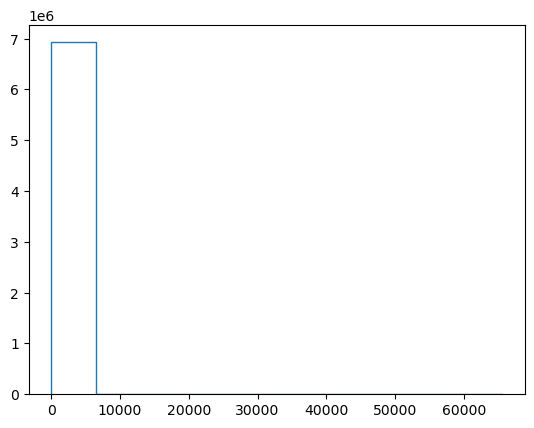

In [49]:
counts, bins = np.histogram(data.flatten())
plt.stairs(counts, bins)

In [51]:
data.flatten().min()

0.0

In [52]:
data.flatten().max()

65532.855

In [107]:
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [114]:
def log_transform(x):
    return np.log(x + 1)


scaler = StandardScaler()
log = FunctionTransformer(log_transform)
pipe = Pipeline(steps=[('log', log) ,
                       #('scaler', scaler)
                      ])
pipe.fit(data)

Pipeline(steps=[('log',
                 FunctionTransformer(func=<function log_transform at 0x7f8bc35b1c60>))])

In [115]:
data_scaled =pipe.transform(data)

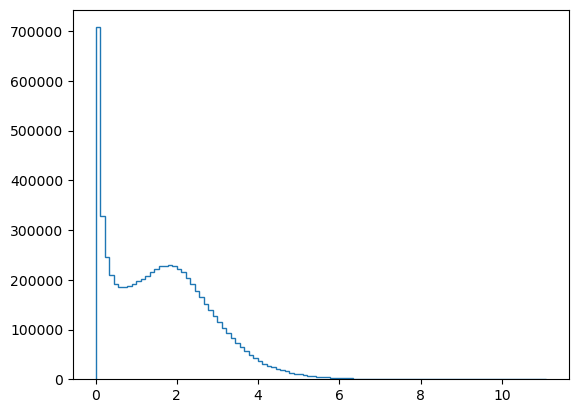

In [116]:
counts, bins = np.histogram(data_scaled.flatten(),bins=100)
plt.stairs(counts, bins)

In [117]:
scaler ={"mean_values" :list(pipe['scaler'].mean_), "var_values" :list(pipe['scaler'].var_)}

KeyError: 'scaler'

In [ ]:
import json
with open('scaler_data.json', 'w') as f:
    json.dump(scaler, f)

In [118]:
data_scaled[:,:100]

array([[3.0496237 , 0.10921305, 2.873022  , ..., 1.4543968 , 1.9622333 ,
        1.9351381 ],
       [3.7938294 , 0.30084515, 3.4583147 , ..., 1.0969776 , 1.5411377 ,
        2.1778946 ],
       [2.6458628 , 0.12071203, 2.8623095 , ..., 1.501719  , 2.1107342 ,
        1.9976348 ],
       ...,
       [3.1515558 , 0.        , 3.37657   , ..., 1.2232753 , 1.00122   ,
        1.9675179 ],
       [2.3620515 , 0.01734868, 2.8170302 , ..., 1.5143797 , 2.1039755 ,
        2.2659314 ],
       [2.698653  , 0.04506898, 2.811124  , ..., 1.0790555 , 2.0535595 ,
        1.9292871 ]], dtype=float32)

In [119]:
import seaborn as sns

In [ ]:
data_scaled_cor =pd.DataFrame(data_scaled).corr()

In [ ]:
data_scaled_cor.mean().mean()

In [ ]:
data_scaled_cor.values.std()

In [ ]:
counts, bins = np.histogram(data_scaled_cor.values.flatten(),bins=100)
plt.stairs(counts, bins)

In [ ]:
sns.clustermap(data_scaled_cor.iloc[:100, :100])

In [ ]:
sns.heatmap(data_scaled_cor.iloc[100:200, 100:200],
            xticklabels=data_scaled_cor.columns[100:200].values,
            yticklabels=data_scaled_cor.columns[100:200].values)